# Notebook 03 – Decision Tree Model & Hyperparameter Tuning

In [1]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Loads dataset

In [2]:
data_path = r"C:/Users/USER/PycharmProjects/ML/data/Telco-Customer-Churn.csv"
df = pd.read_csv(data_path)

## Clean data

In [3]:
df = df.drop("customerID", axis=1)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

## Load Preprocessor

In [4]:
preprocessor = joblib.load("results/preprocessor.pkl")
print("Preprocessor loaded successfully.")

Preprocessor loaded successfully.


## Split Features & Target

In [5]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_pre = preprocessor.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_pre, y, test_size=0.2, random_state=42, stratify=y
)

## Train Baseline Decision Tree

In [6]:
baseline_dt = DecisionTreeClassifier(random_state=42)
baseline_dt.fit(X_train, y_train)

y_pred_baseline = baseline_dt.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

print("Baseline Decision Tree Accuracy (Before Tuning):", baseline_acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_baseline))

Baseline Decision Tree Accuracy (Before Tuning): 0.7288857345635202

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81      1035
           1       0.49      0.51      0.50       374

    accuracy                           0.73      1409
   macro avg       0.65      0.66      0.66      1409
weighted avg       0.73      0.73      0.73      1409



## Hyperparameter Tuning with RandomizedSearchCV

In [7]:
param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 5, 10]
}

rs_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    verbose=1,
    random_state=42
)

rs_dt.fit(X_train, y_train)

print("Best Hyperparameters:", rs_dt.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'gini'}


## Evaluate Tuned Model

In [8]:
best_dt = rs_dt.best_estimator_
y_pred_tuned = best_dt.predict(X_test)
tuned_acc = accuracy_score(y_test, y_pred_tuned)

print("Tuned Decision Tree Accuracy (After Tuning):", tuned_acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))

Tuned Decision Tree Accuracy (After Tuning): 0.7984386089425124

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      1035
           1       0.63      0.57      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



# Confusion Matrix

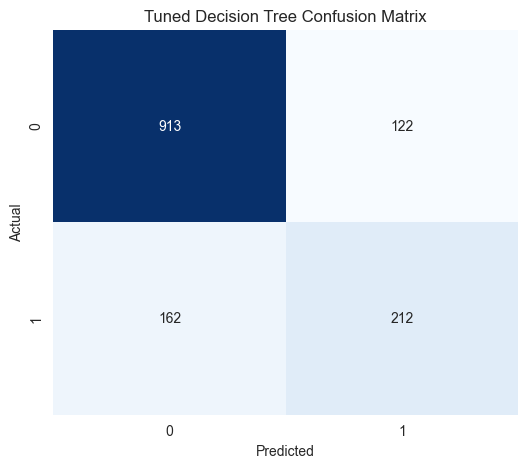

In [9]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Tuned Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

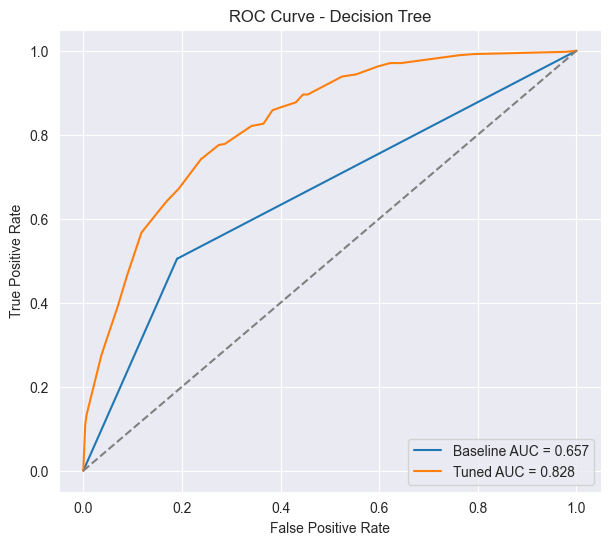

In [11]:
# --- Baseline Decision Tree ---
y_pred_proba_baseline = baseline_dt.predict_proba(X_test)[:, 1]
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_baseline)
roc_auc_base = auc(fpr_base, tpr_base)

# --- Tuned Decision Tree ---
y_pred_proba_tuned = best_dt.predict_proba(X_test)[:, 1]
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plot ROC Curves
plt.figure(figsize=(7, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline AUC = {roc_auc_base:.3f}')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned AUC = {roc_auc_tuned:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Save the Model

In [12]:
joblib.dump(best_dt, "results/decision_tree_model_tuned.pkl")
print("Tuned Decision Tree Model saved as decision_tree_model_tuned.pkl")

Tuned Decision Tree Model saved as decision_tree_model_tuned.pkl
